# Introduction to SolarIrradiance.jl

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Installation" data-toc-modified-id="Installation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Installation</a></span></li><li><span><a href="#Computation-examples" data-toc-modified-id="Computation-examples-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Computation examples</a></span><ul class="toc-item"><li><span><a href="#Transposing-horizontal-irradiance-data-on-a-tilted-plane" data-toc-modified-id="Transposing-horizontal-irradiance-data-on-a-tilted-plane-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Transposing horizontal irradiance data on a tilted plane</a></span></li><li><span><a href="#Effect-of-the-tranposition-method" data-toc-modified-id="Effect-of-the-tranposition-method-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Effect of the tranposition method</a></span></li></ul></li><li><span><a href="#Downloading-GHI-data-from-PVGIS" data-toc-modified-id="Downloading-GHI-data-from-PVGIS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Downloading GHI data from PVGIS</a></span><ul class="toc-item"><li><span><a href="#Transposing-one-year-of-data" data-toc-modified-id="Transposing-one-year-of-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Transposing one year of data</a></span></li></ul></li></ul></div>

## Installation

To install the package, enter the [Pkg REPL](https://pkgdocs.julialang.org/v1/getting-started/)
(pressing `]`, or in Jupyter notebook by prepending a code cell with `]`).
Then use the `add` command with the adress of the repository:

In [ ]:
]add https://github.com/pierre-haessig/SolarIrradiance.jl

## Computation examples

In [1]:
using SolarIrradiance

┌ Info: Precompiling SolarIrradiance [2d82c817-3d9d-4cdc-a094-95b0b9950c3c]
└ @ Base loading.jl:1317


In [2]:
using PyPlot

### Transposing horizontal irradiance data on a tilted plane

Assuming we have the following vector of Global Horizontal Irradiance (GHI) data:

In [3]:
GHI_day = [0.0, 0.0, 0.0, 0.0, 0.0, 39.18, 209.0, 374.0, 240.0, 476.0, 379.0, 619.0, 872.01, 664.0, 680.0, 434.0, 311.0, 313.0, 169.0, 20.88, 0.0, 0.0, 0.0, 0.0];

This contains GHI values at an hourly interval for Rennes on 2012-05-15,
as estimated by the [PVGIS](https://ec.europa.eu/jrc/en/pvgis) Solar radiation tool. It is a rather sunny day, but with some clouds:

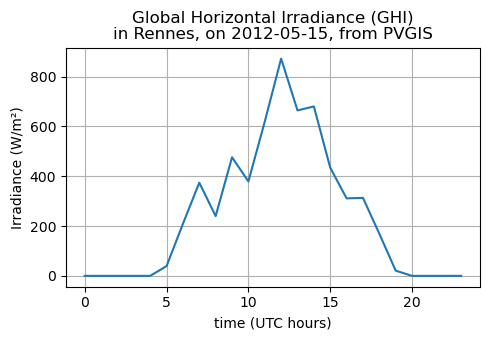

In [4]:
fig, ax = subplots(figsize=(5,3.5))
plot(GHI_day)
ax.grid(true)
ax.set(
    title="Global Horizontal Irradiance (GHI)\nin Rennes, on 2012-05-15, from PVGIS",
    xlabel="time (UTC hours)",
    ylabel="Irradiance (W/m²)",
)
fig.tight_layout()

This horizontal data can be **transposed on tilted plane** using an estimation method (see next section) from the literature. This is implemented in the `global_radiation_tilt` function which requires the following inputs:
- a GHI measurement to be transposed
- day and civil hour of this measurement
    - day `n` as an `Integer` between 1 and 365 or 366
    - civil hour `tc` as UTC, between 0 and 24
    - because GHI measurement are of often averaged over time, you can set the averaging duration with parameter `dt`, in hours. Then `tc`  is the _start_ of the interval.
- location of the measurement: `lat`, `lon` in °
- orientation of the plane for the transposition
    - `slope` between 0° and 90°, with 0° being horizontal
    - `azimuth` between -180° and +180°, with 0° being south-facing and +90° being west-facing

Let's specify these parameters:

In [5]:
# Time of the measurement
n = 136 # can be computed with dayofyear(2012,05,15)
tc = 0:23
dt = 1/60 # 1 minute ~ instantaneous (0.0 is orbidden)

# Location (Rennes, France):
lat = 48.117 #°
lon = -1.678 #°

# Panel orientation:
slope = 40 #°
azimuth = 90 #° → west-facing
albedo = 0.5; # in [0,1]

Now we can tranpose each of the 24 values in a loop (see section below on how to transpose one full year of data):

In [6]:
Gplane = zeros(length(tc))

for (k, tck) in enumerate(tc)
    GHIk = GHI_day[k]
    Gplane[k] = global_radiation_tilt(GHIk, n, tck, dt, lat, lon, slope, azimuth, albedo)
end

Equivalently, a compact vectorized syntax with the ["dot" operator](https://docs.julialang.org/en/v1/manual/mathematical-operations/#man-dot-operators) can be used:

In [7]:
Gplane = global_radiation_tilt.(GHI_day, n, tc, dt, lat, lon, slope, azimuth, albedo);

The effect of the west orientation is visible: less irradiance in the morning, but more in the evening

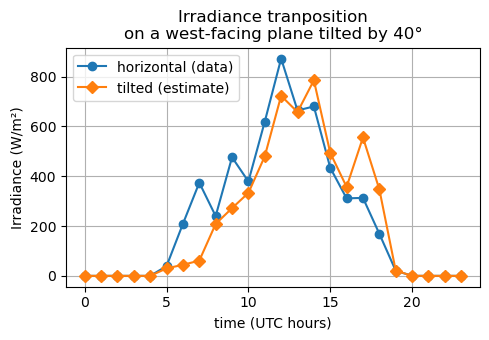

In [57]:
fig, ax = subplots(figsize=(5,3.5))
ax.plot(tc, GHI_day, "o-", label="horizontal (data)")
ax.plot(tc, Gplane, "D-", label="tilted (estimate)")
ax.grid(true)
ax.set(
    title="Irradiance tranposition\non a west-facing plane tilted by $(slope)°",
    xlabel="time (UTC hours)",
    ylabel="Irradiance (W/m²)",
)
ax.legend()
fig.tight_layout()

### Effect of the tranposition method

Many steps of the irradiance transposition from a horizontal plane to a
tilted plane are deduced from geometry. However, two aspects of the
estimation are *empirical*, so that several models are available:

1. splitting the global horizontal irradiance between direct and diffuse components
2. transposing the diffuse irradiance on a tilted plane.
    - In particular, this assumes a certain spatial distribution of the diffuse irradiance on the sky hemisphere. Some models assume an isotropic diffuse irradiance, while more advanced model make various anisotropic assumptions.
    
These choice are set respectively by the `diffuse_model` and `transpose_model` optional parameters.
Each should be a `Symbol` with the initials of the model authors/publication. See the documentation of `global_radiation_tilt` for the list of possible choices. We recommand the article Demain et al. (2013) for an introduction to these models. Some models also come from the Duffie & Beckman textbook.

Default choices are those of the HOMER software (see [How HOMER Calculates the Radiation Incident on the PV Array](https://www.homerenergy.com/products/pro/docs/latest/how_homer_calculates_the_radiation_incident_on_the_pv_array.html)):
- `diffuse_model=:EKD82`: Erbs et al. (1982)
- `transpose_model=:HDKR`: HDKR model (as named in Duffie & Beckman's book)

References:

- Demain, C.; Journée, M. & Bertrand, C.
  “Evaluation of different models to estimate the global solar radiation on inclined surfaces”
  _Renewable Energy_, 2013, 50, 710 - 721 https://doi.org/10.1016/j.renene.2012.07.031
- Duffie, J. A. & Beckman, W. A. “Solar engineering of thermal processes”
  _Wiley_, 2013 


Lets compare the default HDKR anistropic model with the simpler isotropic model from Liu & Jordan (1962)

In [16]:
tm = :LJ62 # Liu & Jordan (1962)
Gplane_tm = global_radiation_tilt.(GHI_day, n, tc, dt, lat, lon, slope, azimuth, albedo;
                                   diffuse_model=:EKD82, transpose_model=tm);

Looking at the result, it is difficult to say more than _both model show the same trend but their output is slighlty different_. It is not possible to say which model is more accurate without the reference from an actual measurement. See Demain et al. (2013) for a comparison of many models. The short story is that no model performs consistently better than the others, because it depends on the sky aspect.

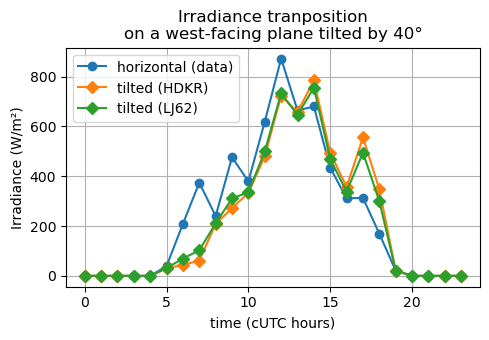

In [56]:
fig, ax = subplots(figsize=(5,3.5))
ax.plot(tc, GHI_day, "o-", label="horizontal (data)")
ax.plot(tc, Gplane, "D-", label="tilted (HDKR)")
ax.plot(tc, Gplane_tm, "D-", label="tilted ($tm)")
ax.grid(true)
ax.set(
    title="Irradiance tranposition\non a west-facing plane tilted by $(slope)°",
    xlabel="time (cUTC hours)",
    ylabel="Irradiance (W/m²)",
)
ax.legend()
fig.tight_layout()

## Downloading GHI data from PVGIS

`SolarIrradiance` provides a submodule `GHIProcess` which can download GHI data from [PVGIS](https://ec.europa.eu/jrc/en/pvgis) Solar radiation tool. The `GHI_download` function downloads one year of data for a given location.

Date and location (Rennes, France):

In [18]:
year = 2012
lat = 48.117 #°
lon = -1.678 #°

-1.678

The download function returns the filename of the downloaded file, saved in the current directory (the optional `basename="GHI_"` argument can change the beginning of the name):

In [19]:
fname = GHIProcess.GHI_download(year, lat, lon)

PVGIS GHI data downloaded and saved as GHI_48.117_-1.678_SA_0deg_0deg_2012_2012.csv


"GHI_48.117_-1.678_SA_0deg_0deg_2012_2012.csv"

Then, the downloaded file can be parsed by:

In [20]:
GHI_year = GHIProcess.GHI_read(fname, year)

8784-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
  70.0
  97.0
  55.0
  68.0
   ⋮
 132.0
  72.0
  85.0
  49.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

For the plot, let's create a time vector in days:

In [49]:
td = collect((0:366*24-1)/24 .+ 1);

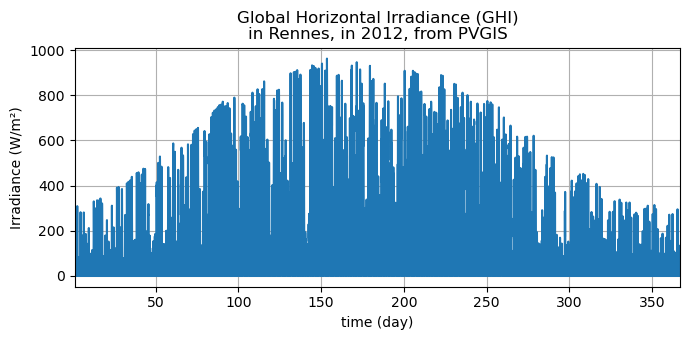

In [53]:
fig, ax = subplots(figsize=(7,3.5))
plot(td, GHI_year)
ax.grid(true)
ax.set(
    title="Global Horizontal Irradiance (GHI)\nin Rennes, in 2012, from PVGIS",
    xlabel="time (day)",
    xlim=(1,367),
    ylabel="Irradiance (W/m²)",
)
fig.tight_layout()

One day of GHI can be extracted by the convenience `sliceday` function (assuming hourly measurements):

In [24]:
n = 136 # (same as example above)
GHI_day = GHIProcess.sliceday(GHI_year, 136);

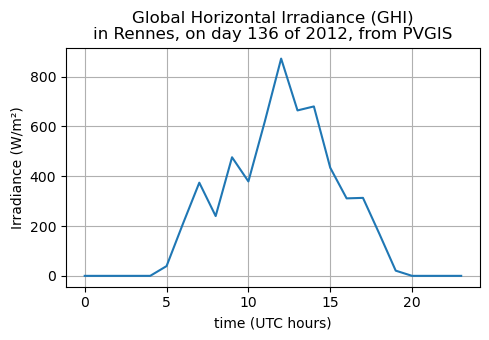

In [37]:
fig, ax = subplots(figsize=(5,3.5))
plot(GHI_day)
ax.grid(true)
ax.set(
    title="Global Horizontal Irradiance (GHI)\nin Rennes, on day $n of $year, from PVGIS",
    xlabel="time (UTC hours)",
    ylabel="Irradiance (W/m²)",
)
fig.tight_layout()

### Transposing one year of data

The above example for transposing one day of data can be adapted to one full year by using two nested loops (day, hour):

In [29]:
Gplane_year = zeros(length(GHI_year))

for n in 1:366 # 2012 is a leap year
    for tc in 0:23
        k = (n-1)*24 + tc + 1
        GHIk = GHI_year[k]
        Gplane_year[k] = global_radiation_tilt(GHIk, n, tc, dt, lat, lon, slope, azimuth, albedo)
    end
end

Plot full year but zoom around day 136 (same as first example). We can see that:
- On day 137 which is very sunny (high amount of direct irradiance coming from the Sun direction), the west-facing tilt has a strong effect. There is almost nothing on the plane in the morning
- On day 138 which is very clouly (majority of diffuse irradiance coming from many directions), the effect of the tilt is not so pronounced 

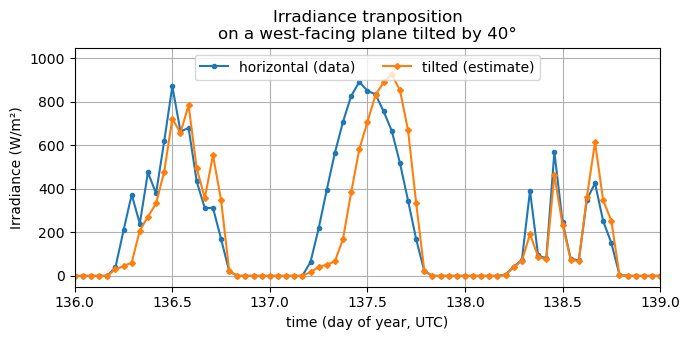

In [58]:
fig, ax = subplots(figsize=(7,3.5))
ax.plot(td, GHI_year, "o-", label="horizontal (data)", ms=3)
ax.plot(td, Gplane_year, "D-", label="tilted (estimate)", ms=3)
ax.grid(true)
ax.set(
    title="Irradiance tranposition\non a west-facing plane tilted by $(slope)°",
    xlabel="time (day of year, UTC)",
    ylabel="Irradiance (W/m²)",
)
ax.legend(ncol=2, loc="upper center")
ax.set_xlim(136, 139)
fig.tight_layout()